<a href="https://colab.research.google.com/github/souravs17031999/Federatedencryption-showcase/blob/master/Keystone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT OBJECTIVE : To implement federated learning and encryption techniques on MNIST dataset using Pytorch and Pysyft

In [0]:
# let's start off by installing privacy preserving deep learning framework pysyft
!pip install syft

## Importing packages

In [0]:
# import all required packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Creating virtual workers

In [0]:
# creating virtual workers
import syft as sy
hook = sy.TorchHook(torch)
# let's create two virtual workers who will hold the data while training the model locally
bob = sy.VirtualWorker(hook, id = "bob")
alice = sy.VirtualWorker(hook, id = "alice")
crypto_provider = sy.VirtualWorker(hook, id="crypto_provider") 

W0813 02:05:57.266631 139640065849216 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0813 02:05:57.284585 139640065849216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



## Setting hyperparameters and device

In [0]:
# This arguments class is simply defining all the hyperparameters of the model we are going to train on
class Arguments():
    def __init__(self):
        self.batch_size = 64 # batch size for training
        self.test_batch_size = 64 # bacth size for testing 
        self.epochs = 10 # no of epochs
        self.lr = 0.01  # setting learning rate
        self.momentum = 0.5 
        self.no_cuda = False  
        self.seed = 1
        self.log_interval = 10
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed) # sets the random seed from pytorch random number generators

device = torch.device("cuda" if use_cuda else "cpu") # choose device based on what is available if cuda or not

print(device)

cpu


## Creating federated dataloader for loading of data and distributing it across the workers

In [0]:
# using .federate method, we can distribute our data across all the workers for now , we have bob and alice
federated_train_loader = sy.FederatedDataLoader( 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), 
    batch_size=64, shuffle=True)

validloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 9575845.36it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135435.06it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2229496.99it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51927.48it/s]            


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## Visualizing dataset

W0813 02:06:30.004012 139640065849216 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape : torch.Size([64, 1, 28, 28])
Label shape : torch.Size([64])
labels: tensor([6, 8, 1, 7, 3, 0, 7, 1, 1, 2, 2, 6, 0, 8, 1, 5, 0, 1, 1, 4, 8, 1, 0, 9,
        3, 5, 6, 7, 0, 1, 9, 0, 7, 6, 0, 3, 2, 7, 7, 3, 8, 6, 9, 2, 2, 0, 9, 9,
        7, 0, 4, 3, 2, 9, 2, 7, 2, 7, 1, 4, 8, 4, 7, 9])


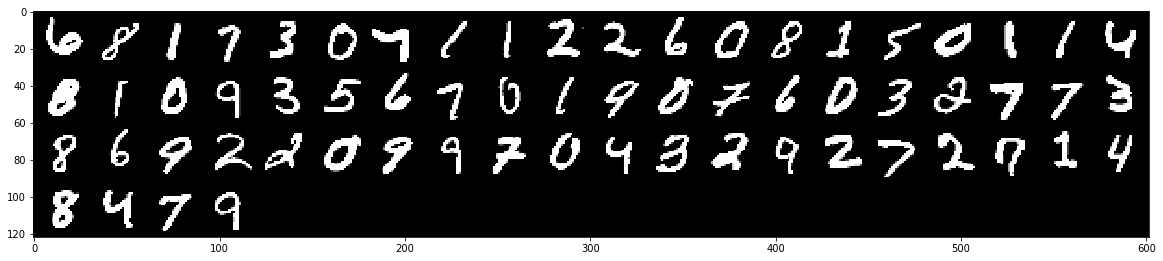

In [0]:
images, labels = next(iter(federated_train_loader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")


# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# plotting the images of loaded batch with given fig size and frame data    
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images.get(), nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels.get()) 

## Checking if cuda is available

In [0]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    

CUDA is not available.  Training on CPU ...


## Defining model architechture

In [0]:
# define the model CNN architechture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
      
        

## Defining optimizer

In [0]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr)


## Defining Training loop and validation loop
### federated learning training

In [0]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses = [] , []
    valid_loss_min = np.Inf 
    model.train()
    print("training started...")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      #scheduler.step()
      for images , labels in federated_train_loader:
        model.send(images.location)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = F.log_softmax(outputs, dim=1)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        model.get()
        running_loss += loss.get().item()
        batch += 1
        if batch % 200 == 0:
          print(f" epoch {epoch + 1} batch {batch} completed")
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          logps = F.log_softmax(logps, dim=1)
          test_loss +=  F.nll_loss(logps, labels)
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(federated_train_loader))
      test_losses.append(test_loss/len(validloader))
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(federated_train_loader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train()
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        valid_loss_min = test_loss/len(validloader)   
    print("Training completed")    
    return train_losses, test_losses

In [0]:
train_losses, test_losses = train_and_test(5)

training started...
 epoch 1 batch 200 completed
 epoch 1 batch 400 completed
 epoch 1 batch 600 completed
 epoch 1 batch 800 completed
Epoch: 1/5..  Training Loss: 0.542..  Valid Loss: 0.304..  Valid Accuracy: 0.915
Validation loss decreased (inf --> 0.304273).  Saving model ...
 epoch 2 batch 200 completed
 epoch 2 batch 400 completed
 epoch 2 batch 600 completed
 epoch 2 batch 800 completed
Epoch: 2/5..  Training Loss: 0.286..  Valid Loss: 0.246..  Valid Accuracy: 0.930
Validation loss decreased (0.304273 --> 0.246335).  Saving model ...
 epoch 3 batch 200 completed
 epoch 3 batch 400 completed
 epoch 3 batch 600 completed
 epoch 3 batch 800 completed
Epoch: 3/5..  Training Loss: 0.237..  Valid Loss: 0.212..  Valid Accuracy: 0.939
Validation loss decreased (0.246335 --> 0.212362).  Saving model ...
 epoch 4 batch 200 completed
 epoch 4 batch 400 completed
 epoch 4 batch 600 completed
 epoch 4 batch 800 completed
Epoch: 4/5..  Training Loss: 0.204..  Valid Loss: 0.188..  Valid Accura

## defining private test loader for encrypting dataset

In [0]:
private_test_loader = []
for data, target in validloader:
    private_test_loader.append((
        data.fix_prec().share(alice, bob, crypto_provider=crypto_provider),
        target.fix_prec().share(alice, bob, crypto_provider=crypto_provider)
    ))

## Encrypting model 

In [0]:
model.fix_precision().share(alice, bob, crypto_provider=crypto_provider)


Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

## Testing on encrypted dataset and encrypted model

In [0]:
def test(args, model, test_loader):
    model.eval()
    n_correct_priv = 0
    n_total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)            
            pred = output.argmax(dim=1) 
            n_correct_priv += pred.eq(target.view_as(pred)).sum()
            n_total += args.test_batch_size
            
            n_correct = n_correct_priv.copy().get().float_precision().long().item()
    
            print('Test set: Accuracy: {}/{} ({:.0f}%)'.format(
                n_correct, n_total,
                100. * n_correct / n_total))

In [0]:
test(args, model, private_test_loader)

Test set: Accuracy: 61/64 (95%)
Test set: Accuracy: 124/128 (97%)
Test set: Accuracy: 185/192 (96%)
Test set: Accuracy: 246/256 (96%)
Test set: Accuracy: 304/320 (95%)
Test set: Accuracy: 364/384 (95%)
Test set: Accuracy: 424/448 (95%)
Test set: Accuracy: 482/512 (94%)
Test set: Accuracy: 542/576 (94%)
Test set: Accuracy: 603/640 (94%)
Test set: Accuracy: 664/704 (94%)
Test set: Accuracy: 725/768 (94%)
Test set: Accuracy: 786/832 (94%)
Test set: Accuracy: 843/896 (94%)
Test set: Accuracy: 903/960 (94%)
Test set: Accuracy: 964/1024 (94%)
Test set: Accuracy: 1025/1088 (94%)
Test set: Accuracy: 1083/1152 (94%)
Test set: Accuracy: 1147/1216 (94%)
Test set: Accuracy: 1210/1280 (95%)
Test set: Accuracy: 1270/1344 (94%)
Test set: Accuracy: 1330/1408 (94%)
Test set: Accuracy: 1389/1472 (94%)
Test set: Accuracy: 1452/1536 (95%)
Test set: Accuracy: 1514/1600 (95%)
Test set: Accuracy: 1578/1664 (95%)
Test set: Accuracy: 1635/1728 (95%)
Test set: Accuracy: 1698/1792 (95%)
Test set: Accuracy: 1757/

## Wooh ! We achived great accuracy while keeping data and model encrypted !